## WIP Truncate the bead

What happens if we truncate the bead?  Is the resulting reconstruction still free of artifacts?  Is the stop iteration calculation still well-behaved?  

Edge artifacts can be severe in deconvoluton, especially in the axial direction.  It is common to collect empty space above and below objects of interest but there are scenarios for which this isn't possible, or we'd like to get away with less slices, less data... so it is something that has practical implications. 

We can handle edges by adapting the strategy of using an ```HTones``` array to properly condition the RL updates as described [here](https://pubmed.ncbi.nlm.nih.gov/24436314/) .  See [here](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/notebooks/Deconvolution/edges.ipynb) for an example which attempts to work out the proper way to calculate ```Htones``` for edges. 

## Load and truncate the bead

size of bead image:  (256, 256, 256)
size of cropped bead image:  (30, 256, 256)


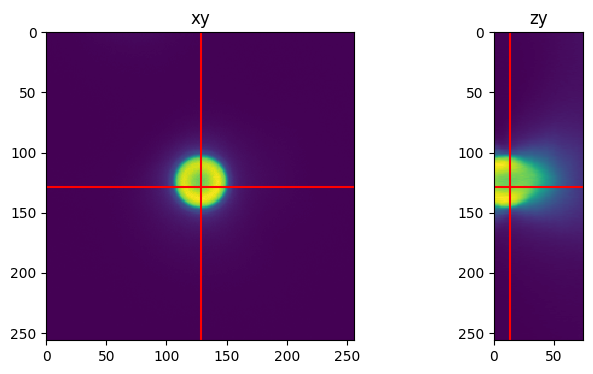

In [12]:
from skimage.io import imread
import numpy as np
from tnia.plotting.projections import show_xy_zy_slice
from richardson_lucy_gradient_consensus_2025_06_22 import rlgc_latest
from richardson_lucy_gradient_consensus_noncirc_2025_06_22 import rlgc_latest_nc
from clij2fft.richardson_lucy import richardson_lucy
from skimage.filters import threshold_otsu
import time

path_=r"D:\images\tnia-python-images\deconvolution\bead"

bead=imread(path_+"/Bead.tif")
print('size of bead image: ',bead.shape)
z_start=75
z_end=105
z_to_view=5

# define the region of interest to speed up the processing
roi=np.s_[z_start:z_end, :, :]
bead=bead[roi]
bead=bead[::-1,:,:]
print('size of cropped bead image: ',bead.shape)
xy_spacing = 0.0645
z_spacing=.16

ratio = z_spacing/xy_spacing

fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(8,4))

## Create a PSF

We use a theoretical PSF but the optical parameters and size in voxels of the PSF need to be chosen.  Optical parameters should be well defined, but size of PSF can be a bit arbitrary.  

If we are measuring the PSF we still need to determine crop size and post processing (cleanup) strategies, or strategies to extract PSF from multiple beads. 

sdeconv 1.x.x detected


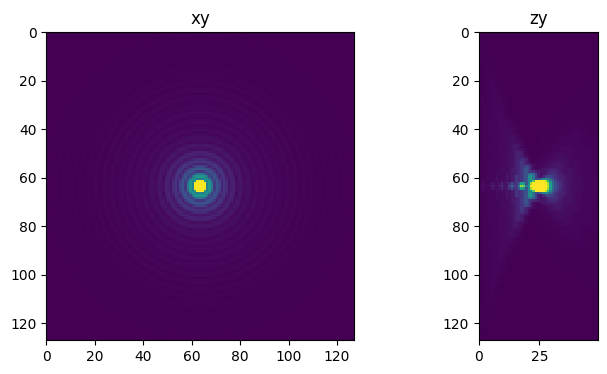

In [14]:
from tnia.nd.ndutil import centercrop
from tnia.deconvolution.psfs import gibson_lanni_3D
from tnia.plotting.projections import show_xy_zy_max
from tnia.deconvolution.psfs import recenter_psf_axial
from skimage.io import imsave

ni=1.518
ns=1.48
NA=1.4
w=0.530

xy_spacing = 0.0645
z_spacing=.16

xy_psf_dim=127 #255
z_compute_psf_dim=599
z_crop_psf_dim=49
z_crop_psf_dim_ = 29

#depth to compute PSF at
d=128*z_spacing

psf  = gibson_lanni_3D(NA, ni, ns, xy_spacing, z_spacing, xy_psf_dim, z_compute_psf_dim, d, w)
psf = psf.astype('float32')

psf=recenter_psf_axial(psf, z_crop_psf_dim)
psf_=recenter_psf_axial(psf, z_crop_psf_dim_)
fig=show_xy_zy_max(psf, vmax=psf.max()/4, figsize=(8,4))
    

## Deconvolve using circulant (base) and non-circulant version of rlgc

In [15]:
recon, best_recon, stat, stop_iteration = rlgc_latest(bead, psf_, 1000, True)
recon_nc, best_recon_nc, stat_nc, stop_iteration_nc = rlgc_latest_nc(bead, psf, stop_iteration, False)

Iteration 001 completed in 0.185 s. KLDs = 0.1348 (image), 0.1367 (split 1), 0.1368 (split 2). Update range: 0.68 to 6.47. Largest relative delta = 0.84536.
Iteration 002 completed in 0.024 s. KLDs = 0.0320 (image), 0.0337 (split 1), 0.0336 (split 2). Update range: 0.83 to 1.58. Largest relative delta = 0.36466.
Iteration 003 completed in 0.022 s. KLDs = 0.0251 (image), 0.0268 (split 1), 0.0268 (split 2). Update range: 0.85 to 1.25. Largest relative delta = 0.19186.
Iteration 004 completed in 0.024 s. KLDs = 0.0232 (image), 0.0248 (split 1), 0.0248 (split 2). Update range: 0.88 to 1.16. Largest relative delta = 0.13198.
Iteration 005 completed in 0.023 s. KLDs = 0.0221 (image), 0.0237 (split 1), 0.0237 (split 2). Update range: 0.90 to 1.13. Largest relative delta = 0.10658.
Iteration 006 completed in 0.023 s. KLDs = 0.0212 (image), 0.0228 (split 1), 0.0228 (split 2). Update range: 0.91 to 1.11. Largest relative delta = 0.09139.
Iteration 007 completed in 0.021 s. KLDs = 0.0205 (image),

In [16]:
stop_iteration, stop_iteration_nc

(233, 85)

Text(0.5, 0.98, 'RLGC non-circular edge strategy deconvolved image')

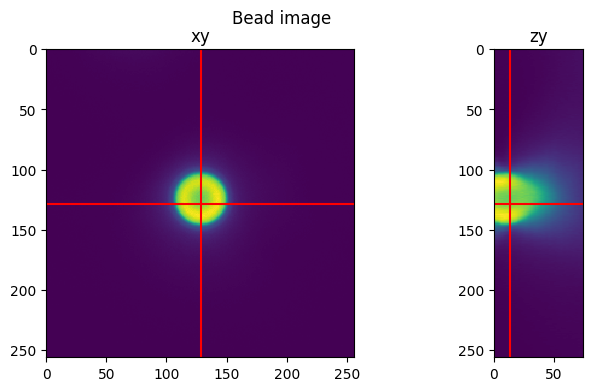

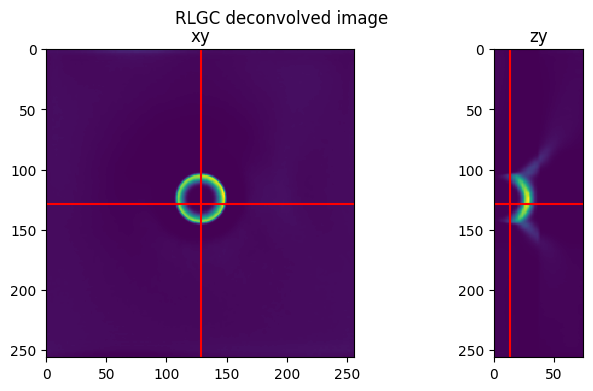

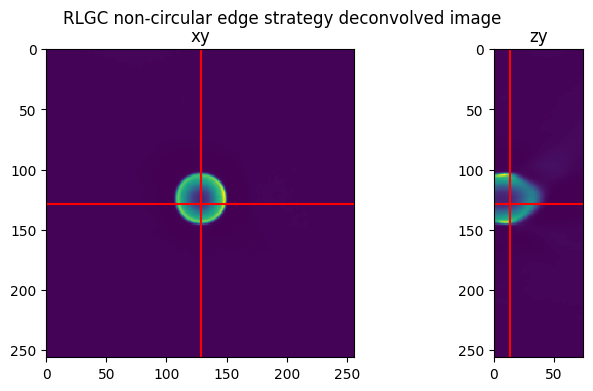

In [18]:
fig=show_xy_zy_slice(bead,128,128,z_to_view, sz=ratio, figsize=(8,4))
fig.suptitle('Bead image')
fig=show_xy_zy_slice(recon,128,128,z_to_view, sz=ratio, figsize=(8,4))
fig.suptitle('RLGC deconvolved image')
fig=show_xy_zy_slice(recon_nc,128,128,z_to_view, sz=ratio, figsize=(8,4))
fig.suptitle('RLGC non-circular edge strategy deconvolved image')